# SI 618 - Homework #6: Machine Learning 1

Version 2021.03.21.2.CT

In this homework exercise you will apply the machine learning techniques we've covered so far: linear regression,
machine learning pipeline, agglomerative clustering, k-means clustering, and t-SNE.

We will be using [graduate admissions data](https://www.kaggle.com/mohansacharya/graduate-admissions).

This is a fairly involved homework assignment and we *strongly* urge you to not leave this to the last minute.
We suggest that you try to work on this assignment over several days.

### The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, punctuation, etc. of written sentences. ([Guide](https://drive.google.com/file/d/1L0P7xJwjUGBvyb49mL3dw1Bt7hzRTiTl/view ))
- 10 pt: Code is written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

In [1]:
MY_UNIQNAME = '' # fill this in with your uniqname
# Do not modify the next three lines
import numpy as np
MY_UNIQHASH = hash(MY_UNIQNAME) & 2**32-1
np.random.seed(MY_UNIQHASH)
print(f"Random seed set to {MY_UNIQHASH}")

Random seed set to 1499873999


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import manifold 
from scipy import stats

In [3]:
admit = pd.read_csv('https://raw.githubusercontent.com/umsi-data-science/data/main/Admission_Predict.csv',
                    index_col="Serial No.")

In [4]:
admit.shape

(400, 8)

In [5]:
admit.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


## Task 1 (5 points):
Perform basic exploratory data analyses on the variables in this dataframe.  Your work should include both
numerical **and** graphical overviews of the data.  The `multiplePlots` code might be helpful here.

In [6]:
# 1. Numerical overview of data
admit.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


In [28]:
# 2. Graphical overview of data: multiplePlots for series
def multiplePlots(series):

    fig, axs = plt.subplots(2, 2)
    fig.suptitle("Plot of " + series.name)
    plt.tight_layout(pad=0.4, w_pad=4, h_pad=1.0)

    # Histogram
    sns.histplot(series, ax=axs[0, 0])

    # Lag plot
    lag = series.copy()
    lag = np.array(lag[:-1])
    current = series[1:]
    ax = sns.regplot(x=current, y=lag, fit_reg=False, ax=axs[0,1])
    ax.set_ylabel("y_i-1")
    ax.set_xlabel("y_i")

    # QQ plot
    qntls, xr = stats.probplot(series, fit=False)
    sns.regplot(x=xr, y=qntls, ax=axs[1,0])

    # Run sequence
    ax = sns.regplot(x=np.arange(len(series)),y=series, ax=axs[1,1])
    ax.set_ylabel("val")
    ax.set_xlabel("i")

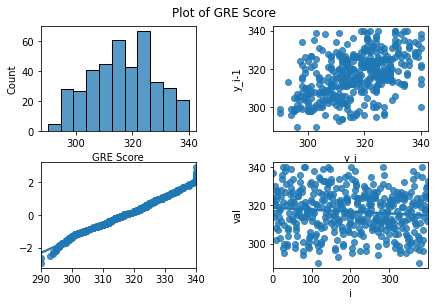

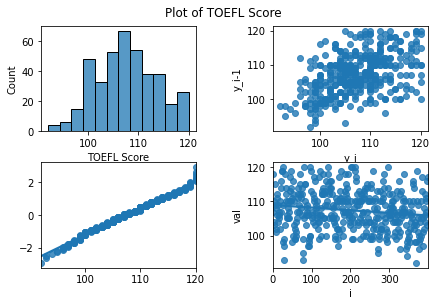

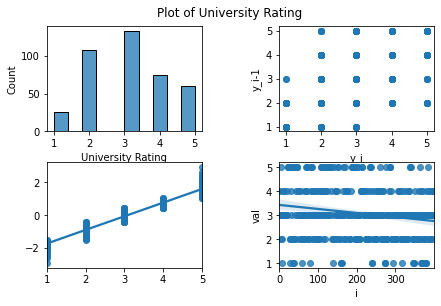

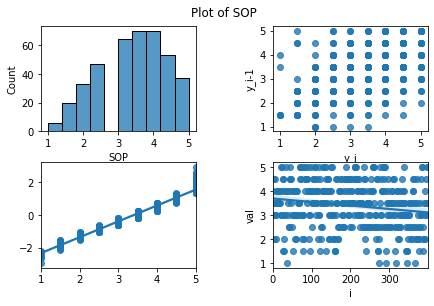

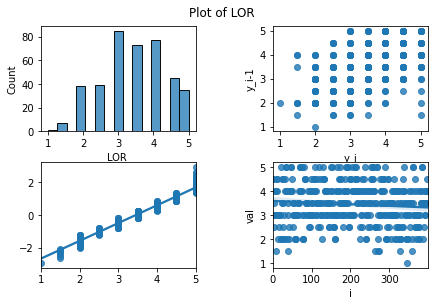

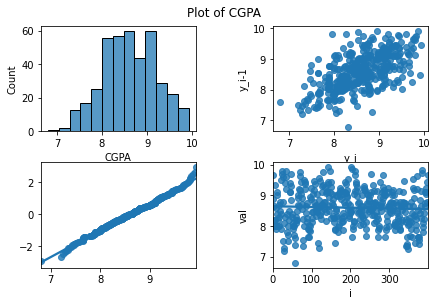

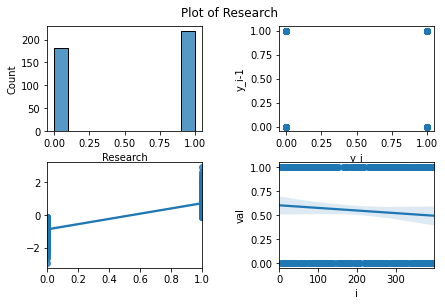

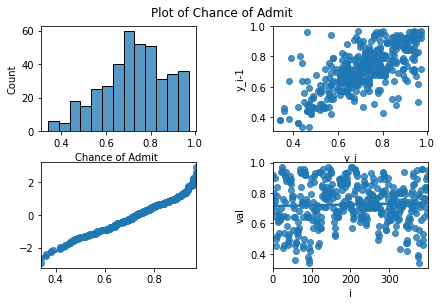

In [29]:
column = list(admit) # get each series in the dataframe
for c in column:
    multiplePlots(admit[c])

**Answer.**

1. Numerical:
By using `admit.describe()`, there are several observations of the data (shown in the table above):
    1. There are in total 400 data points in the dataframe.
    1. The mean of GRE Score is 316.8075, of TOEFL score is 107.41, of University Rating is 3.0875, of SOP is 3.4, of LOR is 3.4525, of CGPA is 8.598925, of Research is 0.54 and of Chance of Admit is 0.72435.
    1. The standard deviation of GRE score is the largest, which means that there exists large variation in GRE score. 
1. Graphical:
By using `multiplePlots` code in the previous class, the histogram, lag plot, QQ plot and run sequence plot of each variable in the dataset are plotted.
    1. From the histograms, university rating seems to have a normal distribution.
    1. From the lag plots, CGPA and Chance of Admit have a slight positive linear trend, which indicates positive autocorrelation.
    1. From the QQ plots, it seems that nearly all variables are linearly related and have normal distributions.

## Task 2a (15 points):
Use scikit-learn to conduct a linear regression that models the chance of admission based on the other variables.  Be sure to exclude "Serial No." as an explanatory variable.  Be sure to pre-process the data appropriately.  Assess how good your model is by reporting the root mean squared error (RMSE) using the test dataset from an 80-20 train-test-split of the original dataset.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [5]:
# 1. Preprocess data
admit.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

In [6]:
admit = admit.rename(columns = {'Chance of Admit ':'Chance of Admit'})
admit.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

In [24]:
train, test = train_test_split(admit, test_size=0.2, random_state=42)
X_train = train.drop('Chance of Admit', axis=1)
X_test = test.drop('Chance of Admit', axis=1)
y_train = train[['Chance of Admit']].copy()
y_test = test[['Chance of Admit']].copy()

In [25]:
ss = StandardScaler()

In [26]:
X_train_prepared = ss.fit_transform(X_train)
X_train_prepared 

array([[ 0.45711129,  0.42466178, -0.057308  , ..., -1.05965163,
         0.13986648,  0.92761259],
       [ 0.1022887 ,  0.42466178, -0.057308  , ..., -0.50194025,
         0.36110014, -1.07803625],
       [ 2.05381293,  2.08593034,  1.6892215 , ...,  1.17119391,
         2.25009529,  0.92761259],
       ...,
       [-0.96217907, -0.40597251, -0.93057275, ..., -0.50194025,
        -0.62594237,  0.92761259],
       [-1.31700165, -1.40273364, -1.8038375 , ..., -1.61736302,
        -2.27668588, -1.07803625],
       [-0.25253389, -0.23984565, -0.93057275, ...,  0.05577114,
        -0.57488845, -1.07803625]])

In [27]:
X_test_prepared = ss.fit_transform(X_test)
X_test_prepared

array([[-1.28554291, -0.52594327, -0.15532561, -0.0200129 ,  0.59681941,
        -0.83818372,  0.83793058],
       [-0.46410974, -0.84713   , -0.15532561,  1.04734184,  0.59681941,
        -0.00540505,  0.83793058],
       [ 1.91804645,  1.07999038,  1.61982426,  0.51366447,  0.59681941,
         1.53203248,  0.83793058],
       [ 0.6858967 ,  0.11643019,  0.73224932,  1.04734184,  0.59681941,
         0.66722387,  0.83793058],
       [-1.28554291, -1.65009682, -1.04290055, -0.55369027, -0.51354229,
        -1.2225431 ,  0.83793058],
       [ 1.91804645,  1.24058374,  1.61982426,  1.04734184,  1.15200026,
         1.29180786,  0.83793058],
       [-1.61411618, -1.81069018, -1.04290055, -1.08736764, -2.17908483,
        -1.20652812, -1.19341628],
       [-1.12125627, -1.32891009, -0.15532561, -1.62104501, -1.06872313,
        -1.57487253, -1.19341628],
       [-0.38196642, -0.3653499 , -1.04290055, -1.62104501, -1.06872313,
        -0.30968957, -1.19341628],
       [ 0.52161006,  0.9193

In [28]:
# 2. Fit a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [29]:
# 3. Test the performance
result = cross_validate(lin_reg, X_test_prepared, y_test, scoring='neg_root_mean_squared_error')
print('RMSE: ' + str(-np.mean(result['test_score'])))

RMSE: 0.06661220774629277


**Answer.**
The result RMSE calculated is around 0.066, which indicates that the linear regression model has a good performance.

## Task 2b (5 points):
Based on your work in the previous task, what is the probability of admission for someone with a GRE score or 325, a TOEFL score of 108, a university rating of 3, an statement of purpose score of 3.0, a letter of recommendation score of 3.5, a high-school grade point average of 8.9, and who has research experience.

In [30]:
# 1. Build the information dataframe
# 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research', 'Chance of Admit'
person = pd.DataFrame({
    'GRE Score': [325],
    'TOEFL Score': [108],
    'University Rating': [3],
    'SOP': [3.0],
    'LOR': [3.5],
    'CGPA': [8.9],
    'Research': [1]
})
person

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,325,108,3,3.0,3.5,8.9,1


In [31]:
# 2. Use the fitted model to predict the possibility
# !! Do not fit your data when doing predictions!
person_prepared = ss.transform(person)
lin_reg.predict(person_prepared)

array([[0.77801215]])

**Answer.**
Based on the previous linear regression model, the probability of admission for this person is around 0.778.

## Task 3 (5 points):
Decide on a reasonable value for a threshold for admission.  Pick a value that you would feel comfortable with if you wanted to know whether you were likely to be accepted into a graduate program.  Create a new variable called "admitted" that is set to 1 if the chance of admission value is equal to or greater than your chosen threshold, 0 otherwise.

In [34]:
admit['admitted'] = np.where(admit['Chance of Admit'] >= 0.80, 1, 0)
admit.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,admitted
Serial No.,,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92,1
2,324,107,4,4.0,4.5,8.87,1,0.76,0
3,316,104,3,3.0,3.5,8.00,1,0.72,0
4,322,110,3,3.5,2.5,8.67,1,0.80,1
5,314,103,2,2.0,3.0,8.21,0,0.65,0


**Answer.**
From Task 1, as the mean value of Chance of Admit is 0.724350, I picked 0.80 to be the standard of a student being admitted into the graduate program.

## Task 4 (20 points):
Using a random sample of approximately 40 rows from the original dataset, conduct an agglomerative clustering analysis using average linkage based on PCA projections of the original data onto 2 dimensions (remember to scale your data before doing the PCA).  Report the percentage of variance retained in the first two principal components. 

Do not use the chance of admission column or the "admitted" variable you created in the previous step in your input data.

Create a dendrogram, pick an appropriate "cut line" and comment on the composition of each of the resulting clusters.  Comment on the degree to which the clusters correspond to admission probabilities (note: you may find it helpful to examine the values of "admitted").

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [129]:
# 1. Clean up data
admit_new = admit.sample(40, random_state=42, axis=0)
X = admit_new.drop(['Chance of Admit', 'admitted'], axis=1)
y = admit_new[['Chance of Admit', 'admitted']].copy()

In [103]:
# 2. Build the pipeline
pipe = Pipeline([
    ('scale',StandardScaler()),                     # scale the data
    ('pca', PCA(n_components=2,random_state=42)),   # 2-component PCA
    ('cluster', AgglomerativeClustering(n_clusters=3, linkage='average')), # Agglomerative Clustering
])

In [130]:
# 3. The percentage of variance retained in the first two principal components
admit_pred = pipe.fit_predict(X)
admit_pred

array([0, 0, 2, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1])

In [132]:
display(pipe.named_steps.pca.explained_variance_ratio_)
display(sum(pipe.named_steps.pca.explained_variance_ratio_))

array([0.72541045, 0.08806288])

0.813473331360096

In [133]:
# 4. Create a dendrogram
# Authors: Mathew Kallada & Chris Teplovs
# License: BSD 3 clause
"""
=========================================
Plot Hierarachical Clustering Dendrogram 
=========================================
This example plots the corresponding dendrogram of a hierarchical clustering
using AgglomerativeClustering and the dendrogram method available in scipy.
"""

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.named_steps.cluster.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    threshold = kwargs.pop('color_threshold')
    plt.axhline(threshold,color='red')

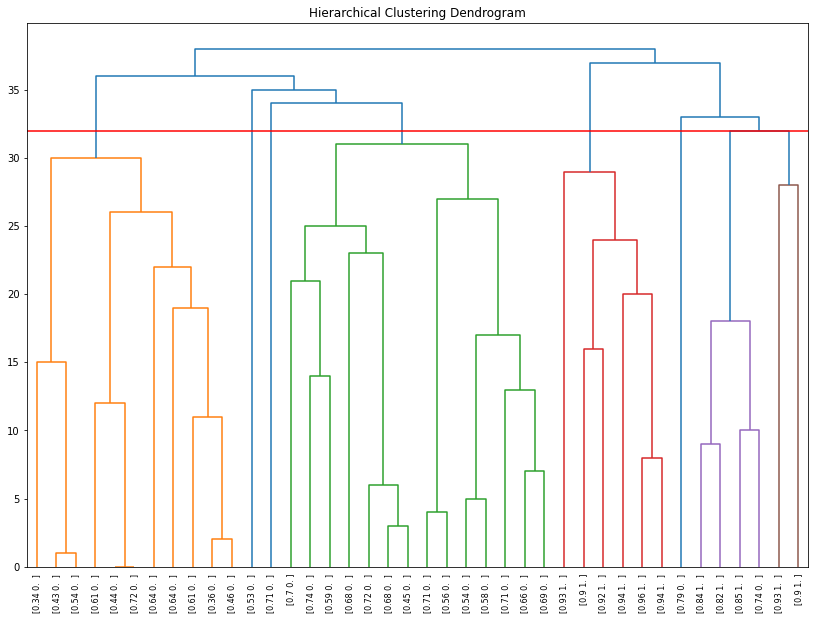

In [149]:
plt.figure(figsize=(14,10))
plt.title('Hierarchical Clustering Dendrogram')

plot_dendrogram(pipe, labels=y.values, color_threshold=32) 
plt.xticks(rotation=90)
plt.show()

**Answer.**
1. The percentage of variance retained in the first two principal components is around 0.813.
1. The threshold is set to be 32, which produces 8 clusters. There are several observations:
    1. The orange cluster has most of Chance of Admit ranging from 0.4 to 0.6.
    1. The green cluster has the most leaves and most of Chance of Admit ranges from 0.5 to 0.7.
    1. Chance of Admit in the red cluster lies above 0.9.
    1. The purple cluster shows the similarity in the range around 0.8.
    1. For the brown cluster, the connection between 0.931 and 0.91 has the smallest distance among all clusters, so the last cluster is most similar.
    1. The remaining 3 clusters are outliers, as the 3 blue lines are completely seperate from others.
    1. The connection between 0.44 and 0.72 has zero distance and is the closest link to the bottom of the dendrogram. Therefore they are most similar in terms of the connection.
1. From the composition presented above, it is clear that similar admission probabilities tend to be in the same cluster.

## Task 5 (20 points):
Conduct a k-means clustering of the complete admissions data.  Pre-process the data using a 2-dimensional PCA (remember to scale your data before doing the PCA).  Again, do not use the chance of admission or the "admitted" variable you created earlier.  Use the average silhouette score to determine the optimal number of clusters and show the silhouette plot for the optimal number of clusters.

In [152]:
from sklearn.cluster import KMeans

In [160]:
# 1. Clean up the admissions data
X = admit.drop(['Chance of Admit', 'admitted'], axis=1).values
X

array([[337.  , 118.  ,   4.  , ...,   4.5 ,   9.65,   1.  ],
       [324.  , 107.  ,   4.  , ...,   4.5 ,   8.87,   1.  ],
       [316.  , 104.  ,   3.  , ...,   3.5 ,   8.  ,   1.  ],
       ...,
       [330.  , 116.  ,   4.  , ...,   4.5 ,   9.45,   1.  ],
       [312.  , 103.  ,   3.  , ...,   4.  ,   8.78,   0.  ],
       [333.  , 117.  ,   4.  , ...,   4.  ,   9.66,   1.  ]])

For n_clusters = 2 The average silhouette_score is : 0.5413034978838358
For n_clusters = 3 The average silhouette_score is : 0.5136919681798997
For n_clusters = 4 The average silhouette_score is : 0.4160834486952309
For n_clusters = 5 The average silhouette_score is : 0.4601853242704151
For n_clusters = 6 The average silhouette_score is : 0.44375864276638266


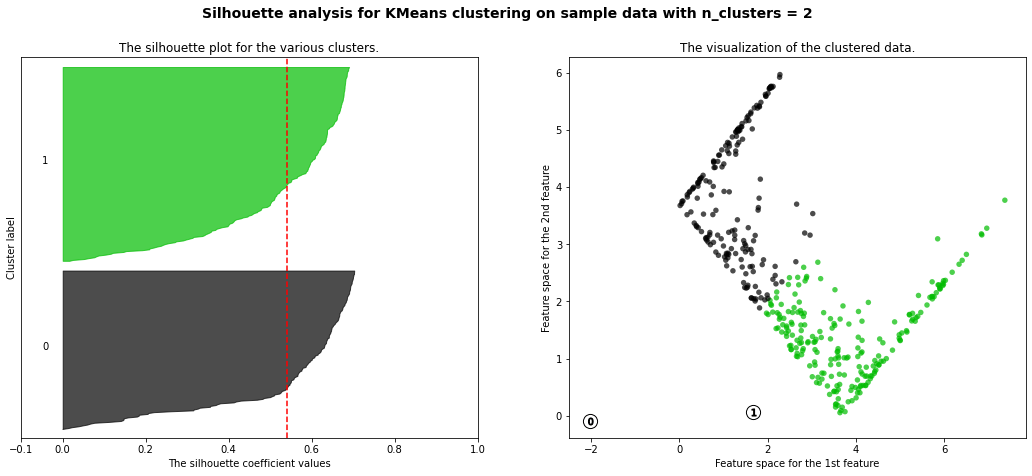

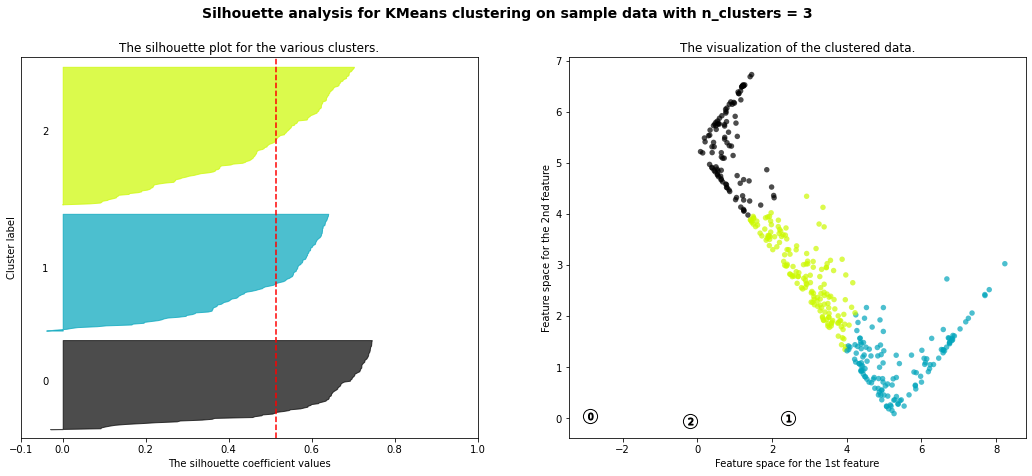

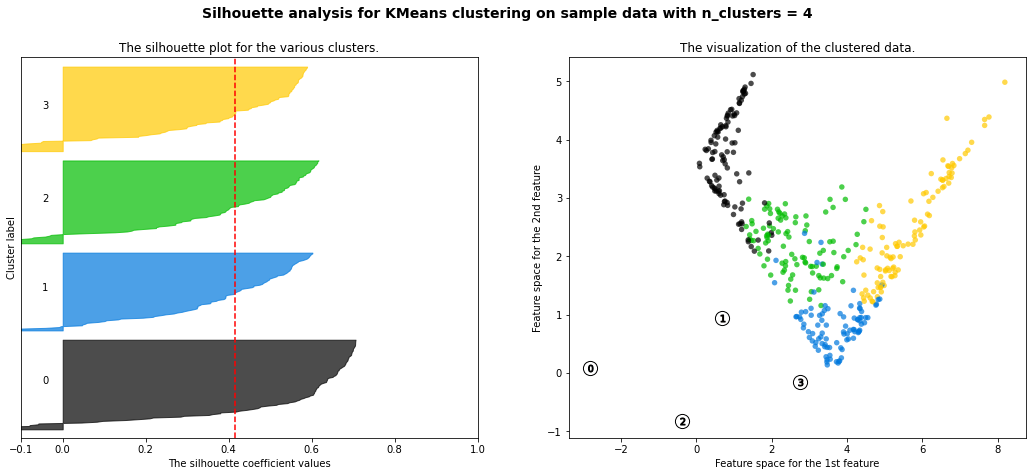

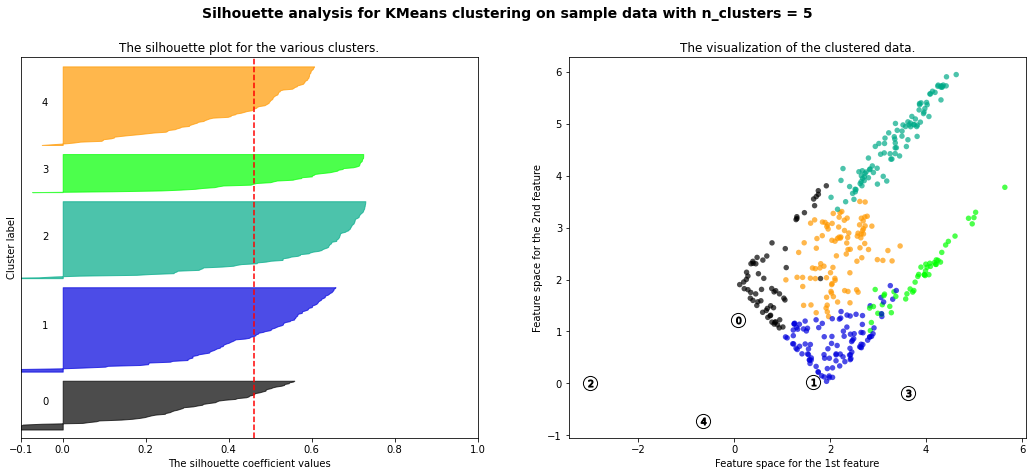

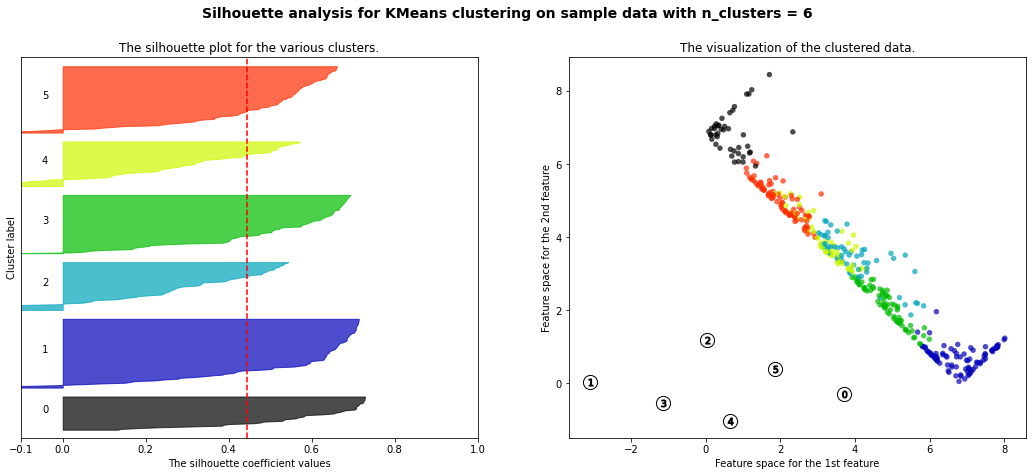

In [161]:
# 2. Pre-process with scale and PCA and use the average silhouette score to determine the optimal number of clusters
# based on https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# Determine if a cluster solution is good / bad

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm # colormaps
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    #cluster_labels = clusterer.fit_predict(X)
    
    # Pre-process with scale and PCA 
    pipe = Pipeline([
        ('scale',StandardScaler()),
        ('pca', PCA(n_components=2,random_state=42)),
        ('cluster', KMeans(n_clusters=n_clusters) ),
    ])
    
    cluster_labels = pipe.fit_predict(X)
    Xtransformed = pipe.transform(X)
    clusterer = pipe.named_steps.cluster

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Xtransformed, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xtransformed, cluster_labels)

    y_lower = 10 
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Xtransformed[:, 0], Xtransformed[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

**Answer.**
1. From the average silhouette_score calculated, the largest score happens when there are two clusters. Therefore, the optimal number of clusters is 2.
1. The optimal plot when the number of clusters equals to 2 is shown as the first plot.

## Task 6 (10 points):
Show the results of a t-SNE analysis of the complete admissions data.  As before, do not use the chance of admission column or the "admitted" variable you created in the previous step in your input data.  Color the points in your visualization based on the "admitted" variable you created earlier.

In [32]:
from sklearn.manifold import TSNE

In [35]:
# 1. Clean up the admissions data
X = admit.drop(['Chance of Admit', 'admitted'], axis=1)
y = admit[['Chance of Admit', 'admitted']].copy()

Text(0.5, 1.0, 'T-SNE analysis of the admission data')

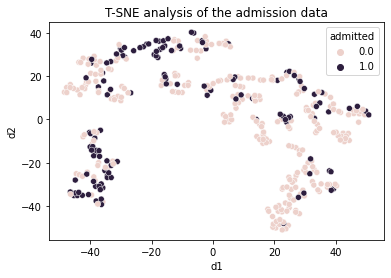

In [42]:
# 2. Plot the results of a t-SNE analysis of the admissions data and color the "admitted" points
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
X_2d = tsne.fit_transform(X)
tsne_labelled = pd.concat([y, pd.DataFrame(X_2d,columns=['d1','d2'])], axis=1)
sns.scatterplot(data=tsne_labelled, x='d1', y='d2', hue='admitted')
plt.title('T-SNE analysis of the admission data')

**Answer.**
The result of the t-SNE analysis of the complete admissions data is shown above and all the "admitted" points are colored. The perplexity is set to be 10. From the graph, it can be found that the clustering structure is not very obvious but there exist two clusters which contain a lot of admitted samples.

# NOTE
We **strongly** recommend restarting your kernel and running your complete notebook from top to bottom
before submitting your work to Canvas in both HTML and IPYNB formats.